# Discrete time Delta Gamma Hedging

@auther: Linlong (Liam) Wu
@date: 2022.11.20
@version: 1

**Functions and model set-ups**

In [1]:
import numpy as np
import pandas as pd
np.seterr(divide='ignore', invalid='ignore')
from scipy.stats import norm
import pdb
import matplotlib.pyplot as plt 
import scipy.stats
from tqdm import tqdm
import seaborn as sns

#np.random.seed(123)
# creating black scholes price and greeks
class BS():
    
    def CallPrice(S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/(np.sqrt(T)*sigma)
        dm = (np.log(S/K) + (r-0.5*sigma**2)*T)/(np.sqrt(T)*sigma)
        
        return S*norm.cdf(dp) - K*np.exp(-r*T)*norm.cdf(dm)
    
    def PutPrice(S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/(np.sqrt(T)*sigma)
        dm = (np.log(S/K) + (r-0.5*sigma**2)*T)/(np.sqrt(T)*sigma)
        
        return K*np.exp(-r*T)*norm.cdf(-dm) - S*norm.cdf(-dp)
    
    
    def CallDelta(S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/(np.sqrt(T)*sigma)
        return norm.cdf(dp)
    
    def PutDelta(S, T, K, sigma, r):
        
        return BS.CallDelta(S, T, K, sigma, r)-1
    
    def CallGamma(S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/np.sqrt(T)/sigma
        
        return norm.pdf(dp)/(S*sigma*np.sqrt(T))
    
    def PutGamma(S, T, K, sigma, r):
        
        return BS.CallGamma(S, T, K, sigma, r)# get s
    
def get_dS(dt, mu, sigma, z, S_last):
    return (mu * S_last * dt + sigma * S_last * z)

# get m
def get_M(M_last, r, dt, delta, delta_last, S, phi_equity, beta, beta_last, O, phi_option):
    return M_last * np.exp(r * dt) - (delta - delta_last) * S - phi_equity * np.abs(delta - delta_last) \
        - (beta-beta_last) * O - phi_option * np.abs(beta-beta_last)

# simulate the stock price movements
def stock_sim(S0, Nsim, timestep, mu, sigma, dt):
    stock = np.zeros((Nsim, timestep + 1))
    stock[:,0] = S0
    for i in range(1, timestep+1):
        z = np.random.normal(0, np.sqrt(1/365), (Nsim, timestep+1))
        stock[:, i] = stock[:, i-1] + get_dS(dt, mu, sigma, z[:, i-1], stock[:, i-1])
    return stock


**Parameters**

In [2]:
phi_equity = 0.005
phi_option = 0.01
timestep = int(365/4)
T_call = 0.5 #Maturity for the call option
S0=100
K=100
Nsim=10000
mu = 0.1
sigma = 0.2
r = 0.02
T = 0.25

# 1. Delta_hedging

**Modelling**

In [3]:
def Delta_hedging_Time(S0, Nsim, timestep, T, K, mu, sigma, r):
    S = stock_sim(S0, Nsim, timestep, mu, sigma, 1/365)
    Delta_time_based = np.full((Nsim, timestep+1), np.nan) # delta positio
    M_time_based = np.full((Nsim, timestep+1), np.nan) # money account
    for i in range(1, timestep+1):
        Delta_time_based[:, 0] = BS.PutDelta(S[:, 0], T, K, sigma, r)
        Delta_time_based[:, i] = BS.PutDelta(S[:, i], T-i/365, K, sigma, r)
        M_time_based[:, 0] = BS.PutPrice(S0, T, K, sigma, r) - Delta_time_based[:, 0] * S0 - phi_equity * np.abs(Delta_time_based[:, 0])
        M_time_based[:, i] = get_M(M_time_based[:, i-1], r, 1/365, Delta_time_based[:, i], Delta_time_based[:, i-1], S[:, i], phi_equity,0,0,0,0)
    # at maturity, liquidate the put and hedge position, pay the difference in strike and stock price if counterparty exercise
    M_time_based[:, -1] = M_time_based[:, -2] * np.exp(r/365) + \
            Delta_time_based[:, -2] * S[:, -1] - phi_equity * np.abs(Delta_time_based[:, -2]) \
                + (S[:, -1] < K) * (- K + S[:, -1])
    M_array = M_time_based[:, -1]
    '''plt.hist(M_array,bins = "auto")
    plt.xlabel('Profit or Loss at time T')
    plt.ylabel('count')
    plt.title('P/L Distribution, Time-based Delta Hedge')
    plt.savefig('Profit Distribition, Time-based Delta Hedge.png')'''
    # calculate the VaR and adjusted price
    confidence = 10
    mean_hedge = np.average(M_array)
    std_hedge = np.std(M_array)
    VaR = np.percentile(M_array, confidence)
    CVaR = np.mean(M_array[M_array<=VaR])
    m = - CVaR - 0.02
    m_discounted = m * np.exp(-r * T)
    price_CVaR_Adjusted = BS.PutPrice(S0, T, K, sigma, r) + m_discounted
    print("Calculated CVaR is {}, the price to chrage is ${}".format(CVaR, price_CVaR_Adjusted))
    results = pd.DataFrame({'Mean': mean_hedge, 'Standard deviation': std_hedge, 'VAR': VaR, 'CVAR': CVaR,'Adjusted Price': price_CVaR_Adjusted}, index=[0])
    return(M_array, results)


def Delta_hedging_Move(S0, Nsim, timestep, T, K, mu, sigma, r, bandwidth):
    ub = np.full(Nsim, -0.01)
    lb = np.full(Nsim, -0.99)

    S = stock_sim(S0, Nsim, timestep, mu, sigma, 1/365)
    Delta_move_based = np.full((Nsim, timestep+1), np.nan)
    M_move_based = np.full((Nsim, timestep+1), np.nan)
    Delta_move_based[:, 0] = BS.PutDelta(S[:, 0], T, K, sigma, r)
    M_move_based[:, 0] = BS.PutPrice(S0, T, K, sigma, r) - Delta_move_based[:, 0] * S0 - phi_equity * np.abs(Delta_move_based[:, 0])
    upper_band = Delta_move_based[:, 0] + bandwidth/2 # set the upper band around the delta
    lower_band = Delta_move_based[:, 0] - bandwidth/2 # set the lower band around the delta
    
    for i in range(1, timestep+1):
        # mark the put delta using a temp variable
        temp = BS.PutDelta(S[:, i], T-i/365, K, sigma, r)
        # locate the positions of the new put delta
        out_ub = np.greater_equal(temp,ub)
        out_lb = np.less_equal(temp,lb)
        out_uband = (1-out_ub)*(np.greater_equal(temp,upper_band))
        out_lband = (1-out_lb)*(np.less_equal(temp,lower_band))
        within_band = (np.greater(temp, lower_band))*(np.less(temp, upper_band))
        # if within band or outside outer boundaries, delta holdings remain unchanged, otherwise update delta
        Delta_move_based[:, i] = Delta_move_based[:, i-1]*(within_band+out_ub+out_lb) + temp*(out_uband+out_lband)
        # reset upper band
        upper_band = Delta_move_based[:, i]+bandwidth/2
        upper_band[np.where(out_ub)] = 0
        upper_band[np.where(out_lb)] = -0.99
        # reset lower band
        lower_band = Delta_move_based[:, i]-bandwidth/2
        lower_band[np.where(out_ub)] = -0.01
        lower_band[np.where(out_lb)] = -1
        # if within band or outside outer boundaries, accure interest on the money account, otherwise re-balance and mark the PnL
        M_move_based[:, i] = M_move_based[:, i-1]*np.exp(r/365)*(within_band+out_ub+out_lb) +\
            get_M(M_move_based[:, i-1], r, 1/365, temp, Delta_move_based[:, i-1], S[:, i], phi_equity,0,0,0,0)*(out_uband+out_lband)
    # at maturity, liquidate the put and hedge position, pay the difference in strike and stock price if counterparty exercise
    M_move_based[:, -1] = M_move_based[:, -2] * np.exp(r/365) + \
            Delta_move_based[:, -2] * S[:, -1] - phi_equity * np.abs(Delta_move_based[:, -2]) \
                + (S[:, -1] < K) * (- K + S[:, -1])
    
    M_array = M_move_based[:, -1]
    '''plt.hist(M_array, bins = "auto")
    plt.xlabel('Profit or Loss at time T')
    plt.ylabel('count')
    plt.title('P/L Distribution, Move-based Delta Hedge')
    plt.savefig('Profit Distribition, Move-based Delta Hedge.png')'''
    # calculate the VaR and adjusted price
    confidence = 10
    mean_hedge = np.average(M_array)
    std_hedge = np.std(M_array)
    VaR = np.percentile(M_array, confidence)
    CVaR = np.mean(M_array[M_array<=VaR])
    m = - CVaR - 0.02
    m_discounted = m * np.exp(-r * T)
    price_CVaR_Adjusted = BS.PutPrice(S0, T, K, sigma, r) + m_discounted
    print("Calculated CVaR is {}, the price to chrage is ${}".format(CVaR, price_CVaR_Adjusted))
    results = pd.DataFrame({'Mean': mean_hedge, 'Standard deviation': std_hedge, 'VAR': VaR, 'CVAR': CVaR,'Adjusted Price': price_CVaR_Adjusted, "Bandwidth": bandwidth}, index=[0])
    return(M_array, results)

**Time_based**

Calculated CVaR is -0.6822695335344608, the price to chrage is $4.392374137792926


,Mean,Standard deviation,VAR,CVAR,Adjusted Price
0,-0.015208,0.363169,-0.448531,-0.68227,4.392374


Calculated CVaR is -0.6709118264653047, the price to chrage is $4.381073077524101


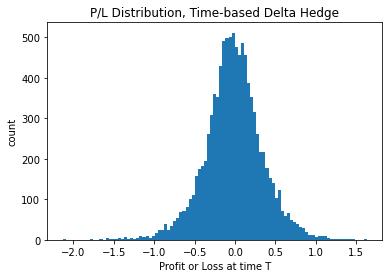

In [4]:
display(Delta_hedging_Time(S0, Nsim, timestep, T, K, mu, sigma, r)[1]) # show the dynamics of Delta hedging
M_array = Delta_hedging_Time(S0, Nsim, timestep, T, K, mu, sigma, r)[0]
plt.hist(M_array,bins = "auto") # plot the PnL at maturity
plt.xlabel('Profit or Loss at time T')
plt.ylabel('count')
plt.title('P/L Distribution, Time-based Delta Hedge')
plt.savefig('Profit Distribition, Time-based Delta Hedge.png')

**Move_based**

Calculated CVaR is -0.8040311113405433, the price to chrage is $4.513528427196169


,Mean,Standard deviation,VAR,CVAR,Adjusted Price,Bandwidth
0,-0.01655,0.432628,-0.549938,-0.804031,4.513528,0.1


Calculated CVaR is -0.7943757822376013, the price to chrage is $4.503921254248029


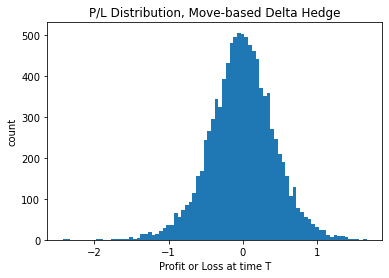

In [5]:
display(Delta_hedging_Move(S0, Nsim, timestep, T, K, mu, sigma, r, 0.1)[1])
M_array = Delta_hedging_Move(S0, Nsim, timestep, T, K, mu, sigma, r, 0.1)[0]
plt.hist(M_array, bins = "auto")
plt.xlabel('Profit or Loss at time T')
plt.ylabel('count')
plt.title('P/L Distribution, Move-based Delta Hedge')
plt.savefig('Profit Distribition, Move-based Delta Hedge.png')

# 2. Delta_Gamma Hedging

**Modelling**

In [6]:
def Delta_Gamma_hedging_Time(S0, Nsim, timestep, T, K, mu, sigma, r):
    S = stock_sim(S0, Nsim, timestep, mu, sigma, 1/365) # stock price movements
    O = np.zeros((Nsim, timestep+1)) # call option price movements
    for j in range(timestep+1):
        O[:, j] = BS.CallPrice(S[:, j], T_call-j/365, K, sigma, r)
    DeltaP_time_based = np.full((Nsim, timestep+1), np.nan)
    DeltaC_time_based = np.full((Nsim, timestep+1), np.nan)
    GammaP_time_based = np.full((Nsim, timestep+1), np.nan)
    GammaC_time_based = np.full((Nsim, timestep+1), np.nan)

    alpha = np.full((Nsim, timestep+1), np.nan) # alpha denotes the holdings in stock
    beta = np.full((Nsim, timestep+1), np.nan) # beta denotes the holdings of call option
    M_time_based = np.full((Nsim, timestep+1), np.nan)
    for i in range(1, timestep+1):
        DeltaP_time_based[:, 0] = BS.PutDelta(S[:, 0], T, K, sigma, r)
        DeltaP_time_based[:, i] = BS.PutDelta(S[:, i], T-i/365, K, sigma, r)
        DeltaC_time_based[:, 0] = BS.CallDelta(S[:, 0], T_call, K, sigma, r)
        DeltaC_time_based[:, i] = BS.CallDelta(S[:, i], T_call-i/365, K, sigma, r)

        GammaP_time_based[:, 0] = BS.PutGamma(S[:, 0], T, K, sigma, r)
        GammaP_time_based[:, i] = BS.PutGamma(S[:, i], T-i/365, K, sigma, r)
        GammaC_time_based[:, 0] = BS.CallGamma(S[:, 0], T_call, K, sigma, r)
        GammaC_time_based[:, i] = BS.CallGamma(S[:, i], T_call-i/365, K, sigma, r)
        # beta is calculated as the fraction of put Gamma and call Gamma
        beta[:, 0] = GammaP_time_based[:, 0]/GammaC_time_based[:, 0]
        beta[:, i] = GammaP_time_based[:, i]/GammaC_time_based[:, i]
        # to hedge against delta exposure, alpha must equal the difference between put delta and call delta
        alpha[:, 0] = DeltaP_time_based[:, 0] - beta[:, 0]*DeltaC_time_based[:, 0]
        alpha[:, i] = DeltaP_time_based[:, i] - beta[:, i]*DeltaC_time_based[:, i]

        M_time_based[:, 0] = BS.PutPrice(S0, T, K, sigma, r) - alpha[:, 0] * S0 - phi_equity * np.abs(alpha[:, 0])\
            - beta[:, 0] * O[:, 0] - phi_option * np.abs(beta[:, 0])
        M_time_based[:, i] = get_M(M_time_based[:, i-1], r, 1/365, alpha[:, i], alpha[:, i-1], S[:, i], phi_equity, beta[:,i], beta[:,i-1], O[:,i], phi_option)
    
    #M_time_based[:, -2] = M_time_based[:, -3] * np.exp(r/365) + beta[:, -3] * O[:, -2] - phi_option * np.abs(beta[:, -3])
    # at maturity, liquidate the put and hedge position, pay the difference in strike and stock price if counterparty exercise
    M_time_based[:, -1] = M_time_based[:, -2] * np.exp(r/365) +\
            alpha[:, -2] * S[:, -1] - phi_equity * np.abs(alpha[:, -2]) \
                + beta[:, -2] * O[:, -1] - phi_option * np.abs(beta[:, -2]) \
                    + (S[:, -1] < K) * (- K + S[:, -1])
                
    M_array = M_time_based[:, -1]
    '''plt.hist(M_array, bins = "auto")
    plt.xlabel('Profit or Loss at time T')
    plt.ylabel('count')
    plt.title('P/L Distribution, Time-based Delta_Gamma Hedge')
    plt.savefig('Profit Distribition, Time-based Delta_Gamma Hedge.png')'''
    # calculate VaR and adjusted price
    confidence = 10
    mean_hedge = np.average(M_array)
    std_hedge = np.std(M_array)
    VaR = np.percentile(M_array, confidence)
    CVaR = np.mean(M_array[M_array<=VaR])
    m = - CVaR - 0.02
    m_discounted = m * np.exp(-r * T)
    price_CVaR_Adjusted = BS.PutPrice(S0, T, K, sigma, r) + m_discounted
    print("Calculated CVaR is {}, the price to chrage is ${}".format(CVaR, price_CVaR_Adjusted))
    results = pd.DataFrame({'Mean': mean_hedge, 'Standard deviation': std_hedge, 'VAR': VaR, 'CVAR': CVaR,'Adjusted Price': price_CVaR_Adjusted}, index=[0])
    return(M_array, results)
 
def Delta_Gamma_hedging_Move_Deviation_based(S0, Nsim, timestep, T, K, mu, sigma, r, bandwidth):
    ub = np.full(Nsim, -0.01)
    lb = np.full(Nsim, -0.99)

    S = stock_sim(S0, Nsim, timestep, mu, sigma, 1/365)
    O = np.zeros((Nsim, timestep+1))
    for j in range(timestep+1):
        O[:, j] = BS.CallPrice(S[:, j], T_call-j/365, K, sigma, r)
    DeltaP_move_based = np.full((Nsim, timestep+1), np.nan)
    DeltaC_move_based = np.full((Nsim, timestep+1), np.nan)
    GammaP_move_based = np.full((Nsim, timestep+1), np.nan)
    GammaC_move_based = np.full((Nsim, timestep+1), np.nan)

    alpha = np.full((Nsim, timestep+1), np.nan)
    beta = np.full((Nsim, timestep+1), np.nan)
    M_move_based = np.full((Nsim, timestep+1), np.nan)
    DeltaP_move_based[:, 0] = BS.PutDelta(S[:, 0], T, K, sigma, r)
    DeltaC_move_based[:, 0] = BS.CallDelta(S[:, 0], T_call, K, sigma, r)
    GammaP_move_based[:, 0] = BS.PutGamma(S[:, 0], T, K, sigma, r)
    GammaC_move_based[:, 0] = BS.CallGamma(S[:, 0], T_call, K, sigma, r)
    beta[:, 0] = GammaP_move_based[:, 0]/GammaC_move_based[:, 0]
    alpha[:, 0] = DeltaP_move_based[:, 0] - beta[:, 0]*DeltaC_move_based[:, 0]
    M_move_based[:, 0] = BS.PutPrice(S0, T, K, sigma, r) - alpha[:, 0] * S0 - phi_equity * np.abs(alpha[:, 0])\
            - beta[:, 0] * O[:, 0] - phi_option * np.abs(beta[:, 0])
    # upper and lower bands are set around the delta of the put position
    deviation_band = np.full(Nsim, bandwidth/2)
    #deviation_band = bandwidth/2
    '''upper_band = DeltaP_move_based[:, 0] + bandwidth/2
    lower_band = DeltaP_move_based[:, 0] - bandwidth/2'''
    for i in range(1, timestep+1):
        temp_alpha = np.zeros((Nsim, 1))
        temp_beta = np.zeros((Nsim, 1))
        temp = np.zeros((Nsim, 1)) # here temp tracks the new put delta
        DeltaP_move_based[:, i] = BS.PutDelta(S[:, i], T-i/365, K, sigma, r)
        temp = DeltaP_move_based[:, i]
        DeltaC_move_based[:, i] = BS.CallDelta(S[:, i], T_call-i/365, K, sigma, r)

        GammaP_move_based[:, i] = BS.PutGamma(S[:, i], T-i/365, K, sigma, r)
        GammaC_move_based[:, i] = BS.CallGamma(S[:, i], T_call-i/365, K, sigma, r)

        temp_beta = GammaP_move_based[:, i]/GammaC_move_based[:, i]
        temp_alpha = DeltaP_move_based[:, i] - temp_beta*DeltaC_move_based[:, i]
        temp_delta_portfolio = alpha[:, i-1] + beta[:, i-1]*DeltaC_move_based[:, i] # calculate the portfolio delta

        deviation = np.abs(temp_delta_portfolio-DeltaP_move_based[:, i]) # track the deviation of portfolio delta from put option delta

        #locate the position of new delta
        out_ub = np.greater_equal(temp,ub)
        out_lb = np.less_equal(temp,lb)
        out_band = (1-out_ub) * (1-out_lb) * np.greater_equal(deviation, deviation_band)
        within_band = np.less(deviation, deviation_band)
        # adjust (or retain) alpha and beta holdings based on delta position
        alpha[:, i] = alpha[:, i-1]*(within_band+out_ub+out_lb) + temp_alpha*(out_band)
        beta[:, i] = beta[:, i-1]*(within_band+out_ub+out_lb) + temp_beta*(out_band)
        deviation_band = np.full(Nsim, bandwidth/2)
        deviation_band[np.where(out_ub)] = 0.005
        deviation_band[np.where(out_lb)] = 0.005
    
        '''lower_band = lower_band*(within_band+out_lb+out_ub) + (temp-bandwidth/2)*(out_uband+out_lband)
        lower_band[np.where(out_ub)] = -0.01
        lower_band[np.where(out_lb)] = -1'''
        M_move_based[:, i] = M_move_based[:, i-1]*np.exp(r/365)*(within_band+out_ub+out_lb) +\
            get_M(M_move_based[:, i-1], r, 1/365, temp_alpha, alpha[:, i-1], S[:, i], phi_equity,temp_beta,beta[:, i-1],O[:, i],phi_option)*(out_band)
    # at maturity, liquidate the put and hedge position, pay the difference in strike and stock price if counterparty exercise
    M_move_based[:, -1] = M_move_based[:, -2] * np.exp(r/365) +\
            alpha[:, -2] * S[:, -1] - phi_equity * np.abs(alpha[:, -2]) \
                + beta[:, -2] * O[:, -1] - phi_option * np.abs(beta[:, -2]) \
                    + (S[:, -1] < K) * (- K + S[:, -1])
    M_array = M_move_based[:, -1]
   
    '''plt.hist(M_array, bins = "auto")
    plt.xlabel('Profit or Loss at time T')
    plt.ylabel('count')
    plt.title('P/L Distribution, Move-based Delta Hedge')
    plt.savefig('Profit Distribition, Move-based Delta Hedge.png')'''
    # calculate the VaR and adjusted price
    confidence = 10
    mean_hedge = np.average(M_array)
    std_hedge = np.std(M_array)
    VaR = np.percentile(M_array, confidence)
    CVaR = np.mean(M_array[M_array<=VaR])
    m = - CVaR - 0.02
    m_discounted = m * np.exp(-r * T)
    price_CVaR_Adjusted = BS.PutPrice(S0, T, K, sigma, r) + m_discounted
    print("Calculated CVaR is {}, the price to chrage is ${}".format(CVaR, price_CVaR_Adjusted))
    results = pd.DataFrame({'Mean': mean_hedge, 'Standard deviation': std_hedge, 'VAR': VaR, 'CVAR': CVaR,'Adjusted Price': price_CVaR_Adjusted, "Bandwidth":bandwidth}, index=[0])
    return(M_array, results)

**Time_based**

Calculated CVaR is -0.3122555518227617, the price to chrage is $4.024205608514013


,Mean,Standard deviation,VAR,CVAR,Adjusted Price
0,-0.137472,0.079159,-0.239659,-0.312256,4.024206


Calculated CVaR is -0.31672159166737857, the price to chrage is $4.0286493738919775


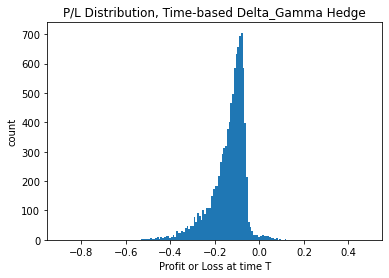

In [7]:
display(Delta_Gamma_hedging_Time(S0, Nsim, timestep, T, K, mu, sigma, r)[1])
M_array = Delta_Gamma_hedging_Time(S0, Nsim, timestep, T, K, mu, sigma, r)[0]
plt.hist(M_array, bins = "auto")
plt.xlabel('Profit or Loss at time T')
plt.ylabel('count')
plt.title('P/L Distribution, Time-based Delta_Gamma Hedge')
plt.savefig('Profit Distribition, Time-based Delta_Gamma Hedge.png')

**Move_based**

Calculated CVaR is -0.516529232523484, the price to chrage is $4.227460469981852


,Mean,Standard deviation,VAR,CVAR,Adjusted Price,Bandwidth
0,-0.067157,0.302297,-0.38926,-0.516529,4.22746,0.1


Calculated CVaR is -0.5134358706206863, the price to chrage is $4.224382536285909


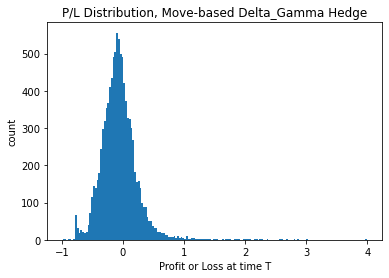

In [8]:
display(Delta_Gamma_hedging_Move_Deviation_based(S0, Nsim, timestep, T, K, mu, sigma, r, 0.1)[1])
M_array = Delta_Gamma_hedging_Move_Deviation_based(S0, Nsim, timestep, T, K, mu, sigma, r, 0.1)[0]
plt.hist(M_array, bins = "auto")
plt.xlabel('Profit or Loss at time T')
plt.ylabel('count')
plt.title('P/L Distribution, Move-based Delta_Gamma Hedge')
plt.savefig('Profit Distribition, Move-based Delta_Gamma Hedge.png')

# 3. Results and Analysis

**Scenario Test for Move-based Hedgings**    (Using KDE)

1. Delta Hedging

Bandwidth = 0
Calculated CVaR is -0.6887456876060433, the price to chrage is $4.398817991911325
Bandwidth = 0.05
Calculated CVaR is -0.7163873477428379, the price to chrage is $4.426321788693039
Bandwidth = 0.1
Calculated CVaR is -0.7984487446989345, the price to chrage is $4.507973902724339
Bandwidth = 0.15
Calculated CVaR is -0.9626148610322031, the price to chrage is $4.671321237136539
Bandwidth = 0.2
Calculated CVaR is -1.127021552778224, the price to chrage is $4.834907947086614


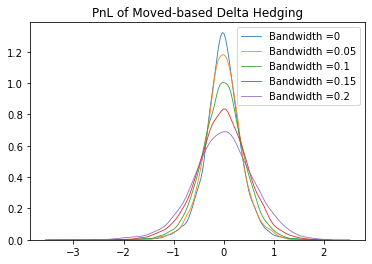

,Mean,Standard deviation,VAR,CVAR,Adjusted Price,Bandwidth
0,-0.012171,0.366843,-0.448456,-0.688746,4.398818,0.00
1,-0.018004,0.379930,-0.476077,-0.716387,4.426322,0.05
2,-0.014032,0.432309,-0.549619,-0.798449,4.507974,0.10
3,-0.016479,0.516737,-0.656909,-0.962615,4.671321,0.15
4,-0.010604,0.611701,-0.759198,-1.127022,4.834908,0.20


In [10]:
Bandwidth = [0, 0.05, 0.1, 0.15, 0.2] # the list of bandwidths to test on
frames = pd.DataFrame()
for b in range(len(Bandwidth)):
    print("Bandwidth = {}".format(Bandwidth[b]))
    M_array, output = Delta_hedging_Move(S0, Nsim, timestep, T, K, mu, sigma, r, Bandwidth[b])
    frames = pd.concat([frames, output], ignore_index=True, sort=False) # record the output
    sns.kdeplot(M_array, linewidth = 0.8, label = 'Bandwidth ={}'.format(Bandwidth[b])) # kde plots of PnL at each bandwidth
    plt.title("PnL of Moved-based Delta Hedging")
plt.legend()
plt.savefig('PnL of Moved-based Delta Hedging.png')
plt.show()
display(frames)


2. Delta_Gamma Hedging

Bandwidth = 0
Calculated CVaR is -0.327516218370906, the price to chrage is $4.039390162170214
Bandwidth = 0.05
Calculated CVaR is -0.2954126814341695, the price to chrage is $4.007446742291938
Bandwidth = 0.1
Calculated CVaR is -0.292360718903267, the price to chrage is $4.004410001487662
Bandwidth = 0.15
Calculated CVaR is -0.3255196643961151, the price to chrage is $4.037403566049916
Bandwidth = 0.2
Calculated CVaR is -0.36805704867273664, the price to chrage is $4.079728794237369


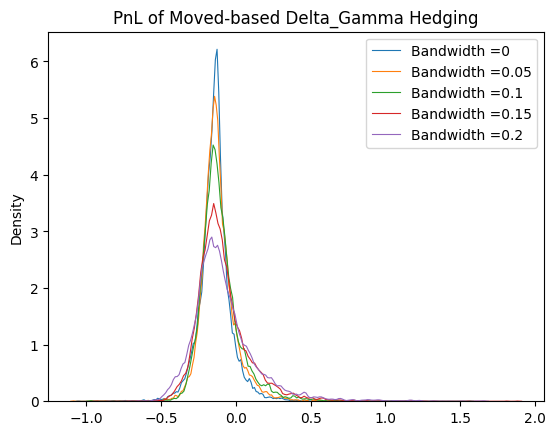

,Mean,Standard deviation,VAR,CVAR,Adjusted Price,Bandwidth
0,-0.136428,0.112884,-0.256119,-0.327516,4.039390,0.00
1,-0.118449,0.121158,-0.236293,-0.295413,4.007447,0.05
2,-0.102987,0.142118,-0.240888,-0.292361,4.004410,0.10
3,-0.090326,0.178336,-0.264747,-0.325520,4.037404,0.15
4,-0.082605,0.217646,-0.296410,-0.368057,4.079729,0.20


In [ ]:
Bandwidth = [0, 0.05, 0.1, 0.15, 0.2]
frames = pd.DataFrame()
for b in range(len(Bandwidth)):
    print("Bandwidth = {}".format(Bandwidth[b]))
    M_array, output = Delta_Gamma_hedging_Move_Deviation_based(S0, Nsim, timestep, T, K, mu, sigma, r, Bandwidth[b])
    frames = pd.concat([frames, output], ignore_index=True, sort=False)
    sns.kdeplot(M_array, linewidth = 0.8, bw_method = 0.05, label = 'Bandwidth ={}'.format(Bandwidth[b]))
    plt.title("PnL of Moved-based Delta_Gamma Hedging")
plt.legend()
plt.savefig('PnL of Moved-based Delta_Gamma Hedging.png')
plt.show()
display(frames)
